## Show difference between 3 subjects in keyboard dataset

In [71]:
from skbio.stats.ordination import pcoa
import pandas as pd
from scipy.spatial.distance import pdist
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import roc_auc_score,  average_precision_score
from q2_anomaly_detection.utils import as_dense
from q2_anomaly_detection.preprocessing import MinMaxScaler
from q2_anomaly_detection.cross_validation import column_value_splitter
from q2_anomaly_detection.datasets import KeyboardDataset
%matplotlib inline

In [72]:
RANDOM_SEED = 724
RAREFACTION_DEPTH = 500
# qiita study 232 with trimming to 90 bp and pick closed reference on 97 otus tree
kbd = KeyboardDataset('data/keyboard')

In [73]:
table = kbd.table

In [74]:
table.shape

(2180, 115)

In [75]:
metadata_all = kbd.metadata

In [76]:
subject_ids = ['M2','M3', 'M9']
metadata = metadata_all.query('host_subject_id in @subject_ids')

In [77]:
metadata = metadata.set_index('sample_name')

In [78]:
metadata['sample_type'].unique()

array(['surface', 'skin'], dtype=object)

In [79]:
metadata['host_subject_id_for_surface'] = [
    tup.host_subject_id if tup.sample_type == 'skin' 
    else np.nan
    for tup in metadata.itertuples()
]

In [80]:
table.filter(metadata.index, axis='sample')

2180 x 104 <class 'biom.table.Table'> with 12380 nonzero entries (5% dense)

In [81]:
np.random.seed(RANDOM_SEED)
subtable = table.subsample(RAREFACTION_DEPTH)
submetadata = metadata.loc[metadata.index.isin(subtable.ids('sample'))]

In [82]:
subtable.shape

(1421, 99)

In [83]:
study_ids = subtable.ids('sample')

In [84]:
dm = pdist(subtable.matrix_data.todense().transpose(), metric='jaccard')

In [85]:
pcoa_results = pcoa(dm)

In [86]:
pcoa_results.samples.index = study_ids

In [87]:
pcoa_with_metadata = pcoa_results.samples.join(metadata)

/Users/garmstro/miniconda3/envs/anomaly-detection-qiime2-2020.11/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


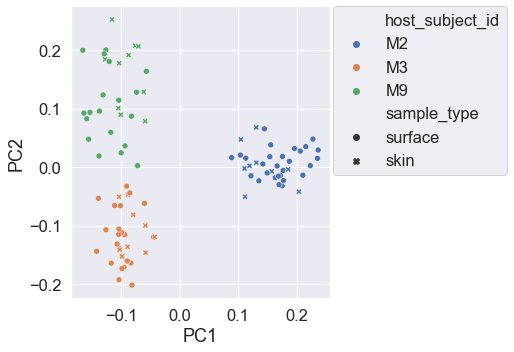

In [88]:
plt.subplots(figsize=(10, 5))
ax = sns.scatterplot('PC1', 'PC2',
                     hue='host_subject_id',
                     style='sample_type',
                     data=pcoa_with_metadata
                     )
ax.set_aspect('equal')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.tight_layout()

In [89]:
pd.unique(pd.Series([2, 1, 3, 3, np.nan]).dropna())

array([2., 1., 3.])

## Show the results of an anomaly detection algorithm of one class v. rest


In [90]:
iso = IsolationForest(contamination="auto")
lof = LocalOutlierFactor(novelty=True,
                         contamination="auto",
                        )
lof_jaccard = LocalOutlierFactor(novelty=True,
                         contamination="auto",
                         metric='jaccard',
                        )
ocsvm = OneClassSVM(gamma='auto')

In [91]:
# CONVENTION: anomaly scores should be transformed onto (0, 1) where 0 is
#  least anomalous and 1 is the most anomalous
models = {
    'IF': {
        'model': iso,
        'scale_score': MinMaxScaler(0, 1, negate=True)
    },
    'LOF': {
        'model': lof,
        'scale_score': MinMaxScaler(0, 1, negate=True)
    },
    'LOF-jaccard': {
        'model': lof_jaccard,
        'scale_score': MinMaxScaler(0, 1, negate=True)
    },
    'ocsvm': {
        'model': ocsvm,
        'scale_score': MinMaxScaler(1, 0)
    },
}

In [92]:
all_results = []
training_category = 'host_subject_id_for_surface'
truth_category = 'host_subject_id'
for model_name, model_attrs in models.items():
    model = model_attrs['model']
    score_scaler = model_attrs['scale_score']
    for val, ids, training_table in column_value_splitter(subtable, submetadata, training_category):
        results = dict()
        results['model_name'] = model_name
        results['category'] = val
        model.fit(as_dense(training_table))
        train_ids = set(training_table.ids('sample'))
        test_table = subtable.filter(train_ids, invert=True, inplace=False)
        scores = model.score_samples(as_dense(test_table))
        scores_scaled = score_scaler.fit_transform(scores)

        non_anomaly_ids = submetadata.loc[(submetadata[truth_category] == val)].index
        # TODO auroc and entropy
        # set not anomaly as 0 and anomaly as 1
        true_labels = [0 if id_ in non_anomaly_ids
                       else 1 for id_ in test_table.ids('sample')]
        results['roc_auc'] = roc_auc_score(true_labels, scores_scaled)
        results['avg_prec'] = average_precision_score(true_labels, scores_scaled)

        results['anomaly_scores'] = [{'sample_id': id_, 'score': score,
                                      'scaled_score': scaled,
                                      'train_test': 'train' if id_ in train_ids else 'test',
                                     } for
                                     id_, score, scaled in zip(
                                         test_table.ids('sample'),
                                         scores, scores_scaled,
                                     )
                                    ]

        all_results.append(results)
        

/Users/garmstro/miniconda3/envs/anomaly-detection-qiime2-2020.11/lib/python3.6/site-packages/sklearn/neighbors/_lof.py:277: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/garmstro/miniconda3/envs/anomaly-detection-qiime2-2020.11/lib/python3.6/site-packages/sklearn/neighbors/_lof.py:277: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/garmstro/miniconda3/envs/anomaly-detection-qiime2-2020.11/lib/python3.6/site-packages/sklearn/neighbors/_lof.py:277: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/garmstro/miniconda3/envs/anomaly-detection-qiime2-2020.11/lib/python3.6/site-packages/sklearn/neigh

In [93]:
results_df = pd.DataFrame(all_results)

In [94]:
res_df = pd.DataFrame.from_dict({(e['model_name'], e['category'], l['sample_id']): 
                                 [l['score'], l['scaled_score'], l['train_test']]
                        for e in all_results
                        for l in e['anomaly_scores']
                       },
                       orient='index',
                       columns=['anomaly_score', 'scaled_score', 'train_test'],
                      )
res_df.index = pd.MultiIndex.from_tuples(res_df.index, names=['model_name', 'category', 'sample_id'])

In [95]:
res_df.reset_index().loc[res_df.reset_index()['model_name'] == 'IF']

,model_name,category,sample_id,anomaly_score,scaled_score,train_test
0,IF,M2,232.M2Dkey217,-0.430397,0.764128,test
1,IF,M2,232.M3Hkey217,-0.394517,0.408826,test
2,IF,M2,232.M3Pinr217,-0.427634,0.736766,test
3,IF,M2,232.M9Indr217,-0.373950,0.205158,test
4,IF,M2,232.M9Thml217,-0.379551,0.260618,test
...,...,...,...,...,...,...
262,IF,M9,232.M9Ykey217,-0.384746,0.116059,test
263,IF,M9,232.M3Akey217,-0.410710,0.350201,test
264,IF,M9,232.M3Ckey217,-0.387584,0.141650,test
265,IF,M9,232.M3Jkey217,-0.390003,0.163467,test


In [96]:
res_df.reset_index().loc[res_df.reset_index()['model_name'] == 'lof-jaccard']

,model_name,category,sample_id,anomaly_score,scaled_score,train_test


In [97]:
res_df['train_test'].value_counts()

test    1068
Name: train_test, dtype: int64

In [98]:
res_with_pc = res_df.reset_index().join(
    pcoa_results.samples[['PC1', 'PC2', 'PC3']], on='sample_id'
).join(
    metadata[['sample_type']], on='sample_id'
)

/Users/garmstro/miniconda3/envs/anomaly-detection-qiime2-2020.11/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


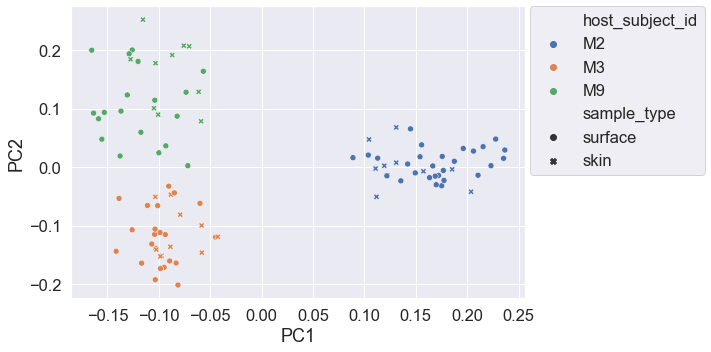

In [99]:
plt.subplots(figsize=(10, 5))
sns.scatterplot('PC1', 'PC2',
                hue='host_subject_id',
                style='sample_type',
                data=pcoa_with_metadata)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.tight_layout()

In [100]:
sns.set(font_scale=1.5)

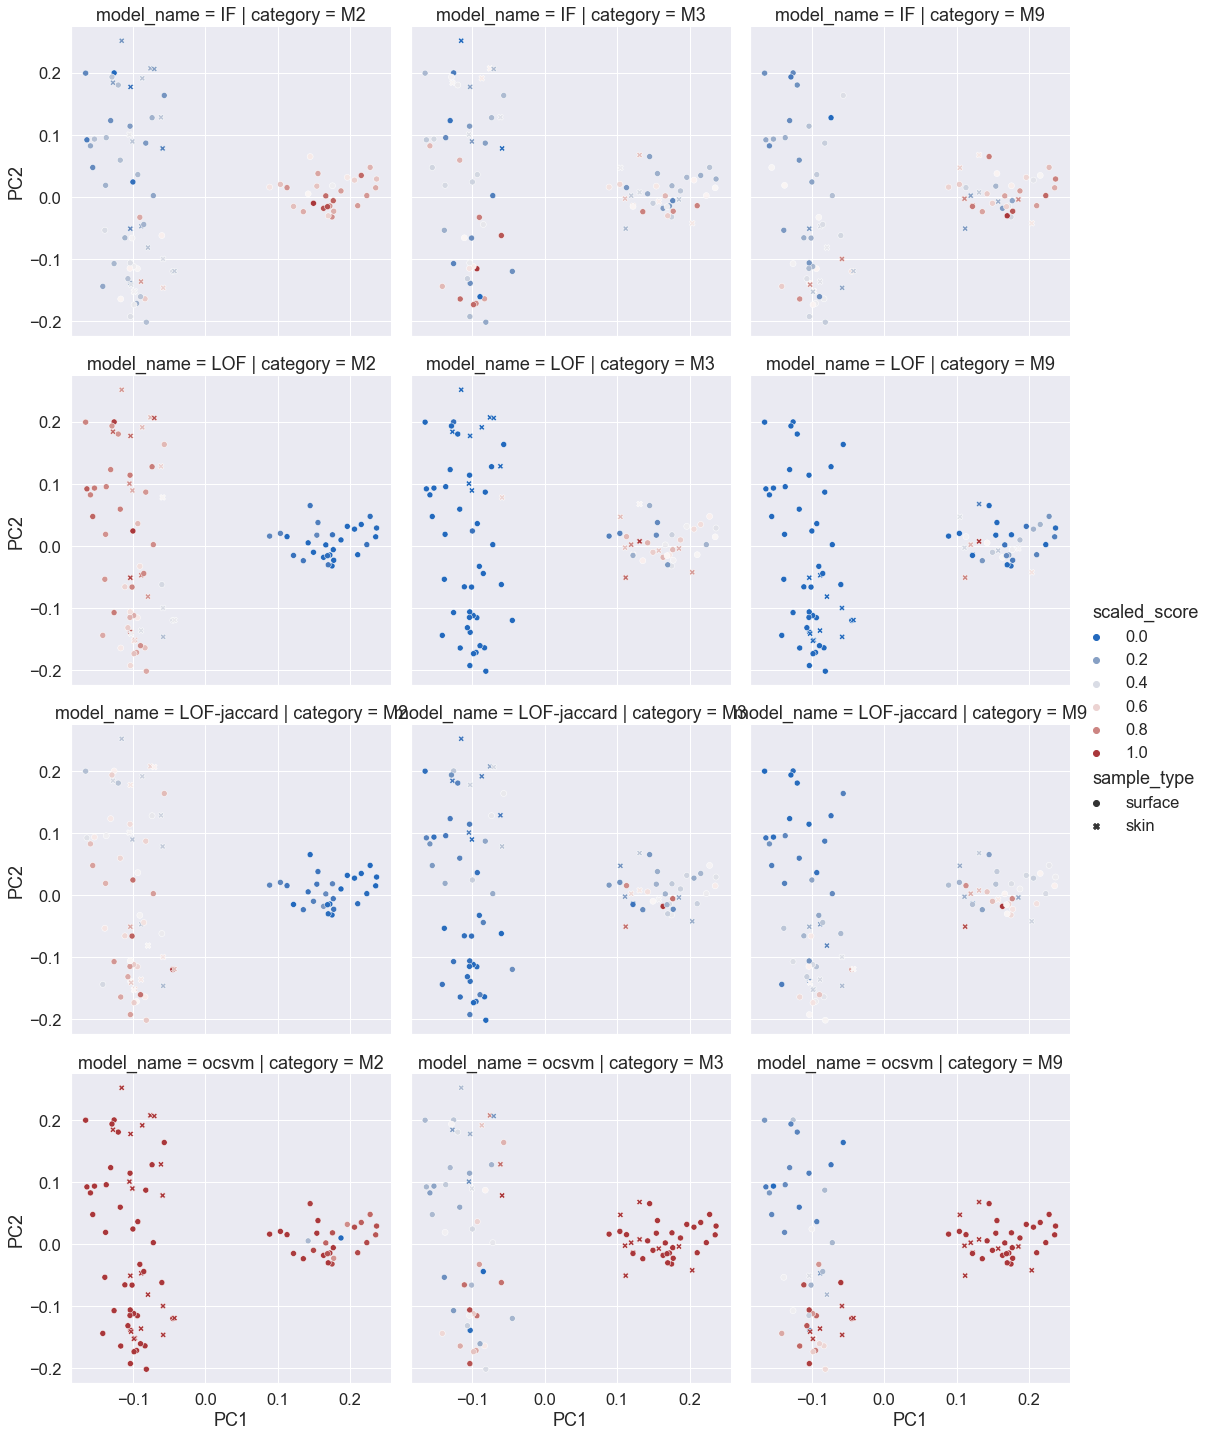

In [101]:
ax = sns.relplot(x='PC1', y='PC2',
            data=res_with_pc,
            col='category',
            row='model_name',
            hue='scaled_score',
            palette='vlag',
            style='sample_type',
            aspect=1,
           )
# ax.set_aspect('equal')

In [102]:
agg_results = pd.DataFrame(all_results).drop('anomaly_scores', axis=1)

In [ ]:
agg_results


,model_name,category,roc_auc,avg_prec
0,IF,M2,0.031616,0.478482
1,IF,M3,0.404342,0.669432
2,IF,M9,0.848872,0.955481
3,LOF,M2,1.000000,1.000000
4,LOF,M3,0.805970,0.904075
5,LOF,M9,0.617669,0.867001
6,LOF-jaccard,M2,1.000000,1.000000
7,LOF-jaccard,M3,0.946744,0.982288
8,LOF-jaccard,M9,0.984962,0.996042
9,ocsvm,M2,1.000000,1.000000
